The goal of this project is to use a dense Neural Net to predict the distances to stars using the derived parameters Teff, Grav, and [Fe/H] from the 
Apogee survey. 

To do this, we used distances from Gaia to create our training sample. We used the apparent magnitude, distance, and extinction measured by WISE
to calculate the absolute magnitudes of the training set to be the labels. This way the model will be trained to find the absolute magnitude
which can then be used to get the distances. I wrote a program that loads the data from the fits file into a csv file that contains extra information
such as the absolute magnitude or the relative uncertainty in the Gaia parallax. 



In [3]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:


data = fits.open('allStarLite-r13-l33-58932beta.fits')

ids = data[1].data['APOGEE_ID']
TEFF = data[1].data['TEFF']
Grav = data[1].data['LOGG']
Metal = data[1].data['M_H']
parallax = data[1].data['GAIA_PARALLAX']
parallax_err = data[1].data['GAIA_PARALLAX_ERROR']
Kmag = data[1].data['K']
carbon = data[1].data['C_FE']
nitrogen = data[1].data['N_FE']


gaia_G = data[1].data['GAIA_PHOT_G_MEAN_MAG']
gaia_BP = data[1].data['GAIA_PHOT_BP_MEAN_MAG']
gaia_RP = data[1].data['GAIA_PHOT_RP_MEAN_MAG']
Vscatter = data[1].data['VSCATTER']

stars = pd.DataFrame()
columns = ['APOGEE_ID','Abs_MAG', 'TEFF', 'Grav', 'Metal','carbon', 'nitrogen', 'Apparent', 'Extinction', 'Parallax_error', 'parallax', 'G', 'BP', 'RP',
           'vscatter']


def extiction():
    # array input/output
    ak= data[1].data['AK_WISE']
    gd=np.where(np.core.defchararray.find( data[1].data['AK_TARG_METHOD'],'IRAC') >= 0)[0]
    ak[gd]= data[1].data['AK_TARG'][gd]
    gd=np.where((abs( data[1].data['GLAT']) > 16) & ((0.302* data[1].data['SFD_EBV'] < 1.2*ak) | (ak<0)) )[0]
    ak[gd]=0.302 *  data[1].data['SFD_EBV'][gd]
    return ak

if True:
    extinction = extiction()
else:
    extinction = data[1].data['AK_WISE']

offset = 0.052 # enter gaia parallax offset here


parallax_error_perc = parallax_err / parallax

Abs_mag = Kmag - 5 * np.log10((1 / ((parallax+offset) / 1000)) / 10) - extinction
star = pd.DataFrame(data=[ids, Abs_mag, TEFF, Grav, Metal, carbon, nitrogen, Kmag, extinction, parallax_error_perc,
                          (parallax + offset),gaia_G, gaia_BP, gaia_RP, Vscatter], index=columns)
stars = star.T

stars = stars[(stars['Abs_MAG'] < 100) & (stars['TEFF'] > 0) & (stars['Grav'] > 0) & (stars['Metal'] > -9000) & (
        stars['Abs_MAG'] > -40) & (stars['Extinction'] > 0) & (stars['parallax']>0)]

stars.to_csv('r13_withCN.csv', index=False) # saves modified data to csv file


C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10


I would then make some plots to see the distribution of the data

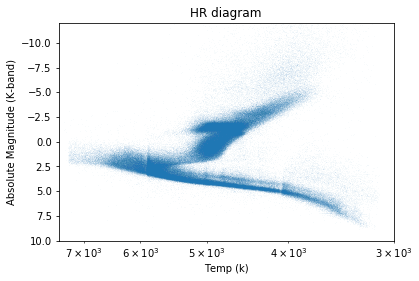

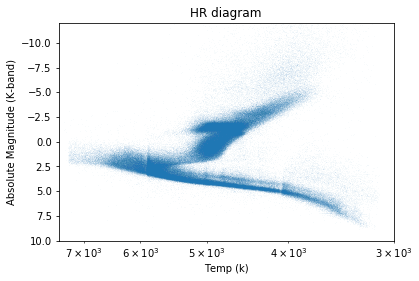

In [8]:
filename = 'Full_DATA_r13_offset.csv'  # file with data.
data = pd.read_csv(filename)
cutoff = 0.15  # Set this to the maximum allowed relative error
data = data[(data['Parallax_error'] < cutoff)]

filename_old = 'Full_DATA_r13_offset.csv'  # file with data.
data_old = pd.read_csv(filename)
cutoff = 0.15  # Set this to the maximum allowed relative error
data_old = data_old[(data_old['Parallax_error'] < cutoff)]



plt.figure()
plt.scatter(data['TEFF'], data['Abs_MAG'],  alpha=0.1, s = 0.01)
plt.xlim(7500, 3000)
plt.xscale('log')
plt.ylim(10, -12)
plt.xlabel('Temp (k)')
plt.ylabel('Absolute Magnitude (K-band)')
plt.title('HR diagram r13 dataset')
plt.show()

plt.figure()
plt.scatter(data_old['TEFF'], data_old['Abs_MAG'],  alpha=0.1, s = 0.01)
plt.xlim(7500, 3000)
plt.xscale('log')
plt.ylim(10, -12)
plt.xlabel('Temp (k)')
plt.ylabel('Absolute Magnitude (K-band)')
plt.title('HR diagram r12 dataset')
plt.show()







For the Neural Net, I used Tensorflow's Keras layers. Before building the model and training though I separate all extra data
that isn't used by the model such as the apparent magnitude, parralax error, etc. I also cut down the dataset based on the relative error of the
parallax. For most of my models I used 0.15 as the cutoff error 

In [14]:

train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

Apparent = train_dataset.pop('Apparent')
Extinction = train_dataset.pop('Extinction')
parallax_error = train_dataset.pop('Parallax_error')
parallax = train_dataset.pop('parallax')
g = train_dataset.pop('G')
G_mag_train = g - 5 * np.log10((1/(parallax/1000)) / 10)
BP = train_dataset.pop('BP')
RP = train_dataset.pop('RP')
vscatter_train = train_dataset.pop('vscatter')


Apparent_test = test_dataset.pop('Apparent')
Extinction_test = test_dataset.pop('Extinction')
parallax_error_test = test_dataset.pop('Parallax_error')
parallax_test = test_dataset.pop('parallax')
g_test = test_dataset.pop('G')
G_mag_test = g_test - 5 * np.log10((1/(parallax_test/1000)) / 10)
BP_test = test_dataset.pop('BP')
RP_test = test_dataset.pop('RP')
vscatter_test = test_dataset.pop('vscatter')



Next I normalize the training parameters

In [15]:
train_stats = data.describe()
train_stats.pop("Abs_MAG")
train_stats.pop('Apparent')
train_stats.pop('Extinction')
train_stats.pop('Parallax_error')
train_stats.pop('parallax')
train_stats.pop('G')
train_stats.pop('RP')
train_stats.pop('BP')
train_stats.pop('vscatter')

train_stats = train_stats.transpose()

train_stats.to_csv('trainstats.csv',  index=True)

train_labels = train_dataset.pop('Abs_MAG')
test_labels = test_dataset.pop('Abs_MAG')


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']



normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


I tested multiple types of model architectures and sizes before settling on a small single layer model. Using keras I made
a sequential model with 16 node input layer and 1 node output layer. The model is trained for a maximum of 500 epochs, but
also has a stop condition which ends training if the validation loss stop decreasing for 15 epochs in a row.

In [16]:
import tensorflow as tf

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model


model = build_model()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

EPOCHS = 500

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[early_stop])


model.save('singlelayerNet_15perc.h5')


Next I would run the test data through the model and analyze the predictions it made vs the true values



In [17]:
test_predictions = model.predict(normed_test_data).flatten()
perc_errors = (test_labels - test_predictions) / test_predictions

distance_test = (1/(parallax_test/1000))

distance_prediction = 10*10**((test_predictions+Extinction_test-Apparent_test)/-5)
regression = (distance_test - distance_prediction) / distance_test



To analyze the results I used a variety of plots

In [18]:

def plot_predict():
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions, alpha=0.3, s = 1)
    plt.xlabel('True Values [Abs_Mag]')
    plt.ylabel('Predictions [Abs_Mag]')
    lims = [-10, 15]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
def plot_regression_hist():
    for i in range(1, 6):
        plt.figure()
        plt.hist(regression[(data['Grav'] < i) & (data['Grav'] > i - 1)], bins=np.arange(-1,1,0.05))
        plt.title('regression histogram for Grav:' + str(i))
        plt.xlim(-1, 1)
        plt.show()




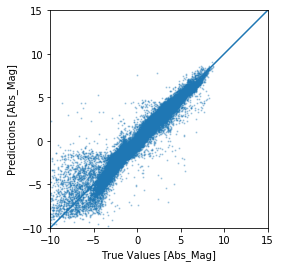

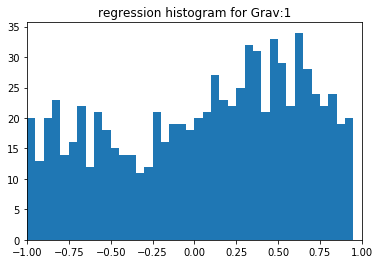

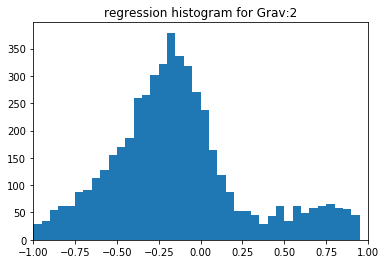

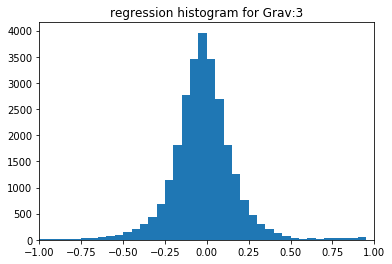

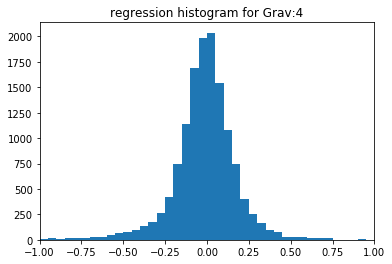

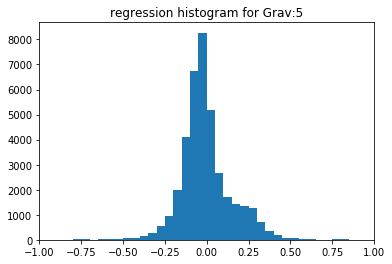

In [19]:
plot_predict()
plot_regression_hist()

At this point one of the issues that I ran into was a bimodol distribution of regressions for nearby dwarf stars. This was found to be caused
by double stars in the training set that the model wasn't expecting. The result was single star distances were trained to be underestimated
due to the model trying to train the whole distribution to be centered on zero. To solve this, I cut out all the binary stars I could indentify
and trained a new model on the dataset with the binary stars cut out. To indentify stars, I wound up using the regression plots from the first model to identify which group of stars 
were likly binaries and then cut thier incices from the data array. (This may have also cut out non binary stars too, but the majority of the stars cut were binaries.

In [23]:
data = pd.read_csv('Full_DATA_r13_offset.csv')

data = data[(data['Parallax_error'] < 0.15)]

Apparent = data.pop('Apparent')
Extinction = data.pop('Extinction')
parallax_error = data.pop('Parallax_error')
parallax = data.pop('parallax')
g = data.pop('G')
G_mag_train = g - 5 * np.log10((1/(parallax/1000)) / 10)
BP = data.pop('BP')
RP = data.pop('RP')
vscatter_train = data.pop('vscatter')



# sns.pairplot(train_dataset[["Abs_MAG", "TEFF", "Grav", "Metal"]], diag_kind="kde")

train_stats = data.describe()
train_stats.pop("Abs_MAG")

train_stats = train_stats.transpose()

test_labels = data.pop('Abs_MAG')


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


normed_test_data = norm(data)

model = tf.keras.models.load_model('singlelayerNet_15perc.h5')

test_predictions = model.predict(normed_test_data).flatten()
perc_errors = (test_labels - test_predictions) / test_predictions

distance_test = (1/(parallax/1000))

distance_prediction = 10*10**((test_predictions+Extinction-Apparent)/-5)
regression = (distance_test - distance_prediction) / distance_test


Starstocut = data[(data['Grav'] < 5) & (data['Grav'] > 4)& (regression>0.15)]

data = pd.read_csv('Full_DATA_r13_offset.csv')

data_withoutBinaries = data.drop(Starstocut.index)

data_withoutBinaries.to_csv('noBinaries_data_r13.csv', index=False)

The new dataset is saved and then the model training and saving process is repeated but with a new dataset

In [24]:
data = pd.read_csv('noBinaries_data_r13.csv')


data = data[(data['Parallax_error'] < 0.15)]


train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

train_dataset.to_csv('trainsample.csv')
test_dataset.to_csv('testsample.csv')


Apparent = train_dataset.pop('Apparent')
Extinction = train_dataset.pop('Extinction')
parallax_error = train_dataset.pop('Parallax_error')
parallax = train_dataset.pop('parallax')
g = train_dataset.pop('G')
G_mag_train = g - 5 * np.log10((1/(parallax/1000)) / 10)
BP = train_dataset.pop('BP')
RP = train_dataset.pop('RP')
vscatter_train = train_dataset.pop('vscatter')


Apparent_test = test_dataset.pop('Apparent')
Extinction_test = test_dataset.pop('Extinction')
parallax_error_test = test_dataset.pop('Parallax_error')
parallax_test = test_dataset.pop('parallax')
g_test = test_dataset.pop('G')
G_mag_test = g_test - 5 * np.log10((1/(parallax_test/1000)) / 10)
BP_test = test_dataset.pop('BP')
RP_test = test_dataset.pop('RP')
vscatter_test = test_dataset.pop('vscatter')



train_stats = data.describe()
train_stats.pop("Abs_MAG")
train_stats.pop('Apparent')
train_stats.pop('Extinction')
train_stats.pop('Parallax_error')
train_stats.pop('parallax')
train_stats.pop('G')
train_stats.pop('RP')
train_stats.pop('BP')
train_stats.pop('vscatter')

train_stats = train_stats.transpose()

train_stats.to_csv('trainstats.csv',  index=True)

train_labels = train_dataset.pop('Abs_MAG')
test_labels = test_dataset.pop('Abs_MAG')


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']



normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model


model = build_model()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

EPOCHS = 500

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[early_stop])


model.save('singlelayerNet_15perc_cutBinaries.h5')


In [25]:
test_predictions = model.predict(normed_test_data).flatten()
perc_errors = (test_labels - test_predictions) / test_predictions

distance_test = (1/(parallax_test/1000))

distance_prediction = 10*10**((test_predictions+Extinction_test-Apparent_test)/-5)
regression = (distance_test - distance_prediction) / distance_test

In [26]:
# Here are the various plotting functions I made

def plot_predict():
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions, alpha=0.3, s = 1)
    plt.xlabel('True Values [Abs_Mag]')
    plt.ylabel('Predictions [Abs_Mag]')
    lims = [-10, 15]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)


def plot_regression(lims=[-15, 15], alpha=0.05):
    regression = (test_labels - test_predictions)
    plt.scatter(test_labels, regression, alpha=alpha)
    plt.xlabel('True Values [Abs_Mag]')
    plt.ylabel('regression [Abs_Mag]')
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, np.zeros(len(lims)))


def histogram(range=[-1, 1], bins=50):
    plt.figure()
    plt.hist(perc_errors, bins=bins, range=range)
    plt.show()

def plot_hr(Mag=test_labels):
    plt.figure()
    plt.scatter(test_dataset['TEFF'], Mag, c=test_dataset['Grav'], alpha=0.1, s = 0.01)
    plt.xlim(7500, 3000)
    plt.xscale('log')
    plt.ylim(10, -12)
    plt.xlabel('Temp (k)')
    plt.ylabel('Absolute Magnitude (K-band)')
    plt.title('HR diagram')
    plt.show()

def plot_error_hr():
    plt.figure()
    plt.scatter(test_dataset['TEFF'], test_labels, alpha=0.1)
    plt.scatter(test_dataset['TEFF'][abs(perc_errors) > 0.3], test_labels[abs(perc_errors) > 0.3], alpha=0.1)
    plt.xlim(7500, 3000)
    plt.xscale('log')
    plt.ylim(10, -12)
    plt.xlabel('Temp (k)')
    plt.ylabel('Absolute Magnitude (K-band)')
    plt.title('HR diagram (Where relative error > 0.3)')
    plt.show()

def plot_parallaxerror_hr():
    plt.figure()
    plt.scatter(test_dataset['TEFF'], test_predictions, c=parallax_error_test, alpha=0.1)
    plt.xlim(7500, 3000)
    plt.xscale('log')
    plt.ylim(10, -12)
    plt.xlabel('Temp (k)')
    plt.ylabel('Absolute Magnitude (K-band)')
    plt.title('HR diagram')
    plt.show()

def regression_pergrav():
    for i in range(1, 6):
        plt.figure()
        plt.scatter(distance_test[(data['Grav'] < i) & (data['Grav'] > i - 1)],
                    regression[(data['Grav'] < i) & (data['Grav'] > i - 1)], s=0.01)
        plt.ylim([-1, 1])
        plt.xlim([-100, 4000])
        plt.title('regression plot for Grav:' + str(i) + ' -No flattening model')
        plt.show()


def plot_predict_dist():
    plt.figure()
    a = plt.axes(aspect='equal')
    plt.scatter(distance_test, distance_prediction, s=0.01, alpha=0.3)
    plt.xlabel('True Values [Abs_Mag]')
    plt.ylabel('Predictions [Abs_Mag]')
    lims = [0, 10000]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()

def gaia_hr():
    plt.figure()
    plt.scatter((BP - RP), G_mag_test, s=1, alpha=0.1)
    plt.xlim(0, 5)
    plt.ylim(13, -2)
    plt.xlabel('Gaia BP-RP colour')
    plt.ylabel('Absolute Magnitude Gaia G')
    plt.title('Gaia HR diagram')
    plt.show()

def plot_regression_hist():
    for i in range(1, 6):
        plt.figure()
        plt.hist(regression[(data['Grav'] < i) & (data['Grav'] > i - 1)], bins=np.arange(-1,1,0.05))
        plt.title('regression histogram for Grav:' + str(i) )
        plt.xlim(-1, 1)
        plt.show()

Now for some analysis. First I checked for any interesting or strange patterns in the histograms of the regression. I also binned the data by Log G
to see any effects dependant on Log G

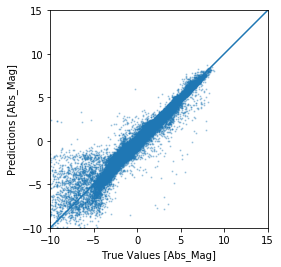

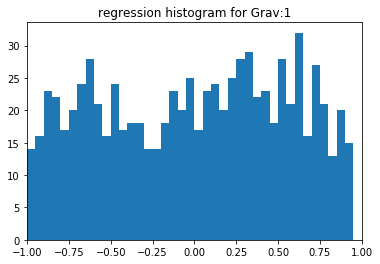

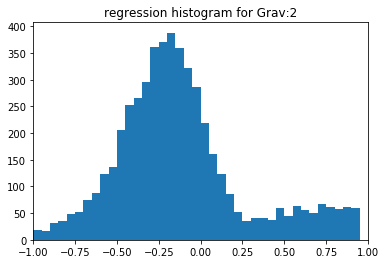

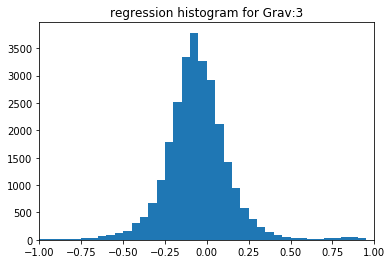

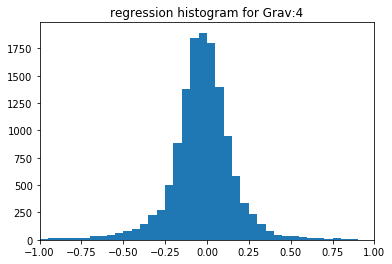

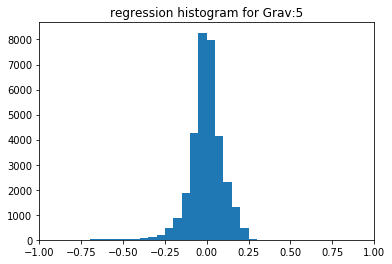

In [27]:
plot_predict()
plot_regression_hist()

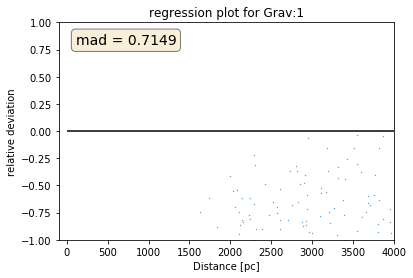

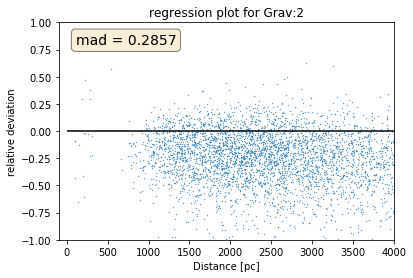

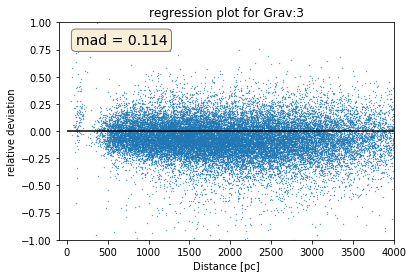

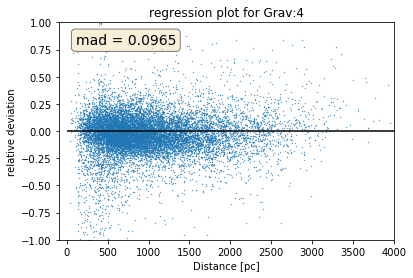

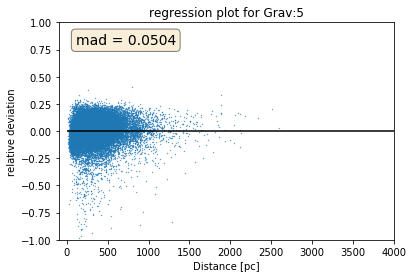

In [28]:
for i in range(1, 6):
    fig, ax = plt.subplots()
    ax.scatter(distance_test[(data['Grav'] < i) & (data['Grav'] > i - 1)],
                regression[(data['Grav'] < i) & (data['Grav'] > i - 1)], s=0.1)
    ax.hlines(0,1,4000)
    mad = np.round(np.median(abs(regression[(data['Grav'] < i) & (data['Grav'] > i - 1)])), decimals=4)
    ax.set_ylim([-1, 1])
    ax.set_ylabel('relative deviation')
    ax.set_xlim([-100, 4000])
    ax.set_xlabel('Distance [pc]')
    ax.set_title('regression plot for Grav:' + str(i))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, 'mad = '+ str(mad), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    plt.show()